In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from utils import extract_basic_features

import wfdb
import wfdb.processing as wp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
from utils import find_noise_features, extract_basic_features
import shutil

import time
from scipy import sparse
import os
import warnings
warnings.filterwarnings("ignore")
import scipy.io as sio
import pywt

from resnet_ecg.utils import one_hot,get_batches
from resnet_ecg.ecg_preprocess import ecg_preprocessing
from resnet_ecg.densenet import DenseNet


Using TensorFlow backend.


In [2]:
train_dataset_path = os.getcwd()+"/Train/"
val_dataset_path = os.getcwd()+"/Val/"

train_files = os.listdir(train_dataset_path)
train_files.sort()
val_files = os.listdir(val_dataset_path)
val_files.sort()

In [3]:
labels = pd.read_csv("reference.csv")
labels.head()

,File_name,label1,label2,label3,label4,label5,label6,label7,label8
0,TRAIN0001,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN0002,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN0003,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN0004,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRAIN0005,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ecg = sio.loadmat(os.path.join(train_dataset_path,train_files[3966]))
ecg['I'].shape

(1, 8500)

In [5]:
ecg['I'][:,-10:]

array([[0.01562, 0.01649, 0.0191 , 0.02604, 0.03385, 0.03646, 0.03212,
        0.02517, 0.02257, 0.02517]])

In [6]:
step = int((5000- 9 * 500)/9)
step

55

In [7]:
winSize = 9*500
for i in range(10):
    print(i*step)
    print(ecg['I'][:,i*step:i*step+winSize][:,-5:])
print(i*step+winSize)

0
[[-0.00608 -0.00781 -0.01128 -0.01997 -0.03559]]
55
[[-0.00087 -0.01042 -0.02344 -0.03906 -0.04774]]
110
[[-0.00347 -0.00694 -0.01128 -0.01562 -0.01649]]
165
[[0.00955 0.01215 0.01389 0.01302 0.0026 ]]
220
[[-0.01302 -0.00781 -0.00521 -0.00174  0.     ]]
275
[[0.02517 0.01302 0.01389 0.02865 0.04514]]
330
[[-0.01476 -0.02083 -0.02691 -0.02865 -0.02778]]
385
[[-0.01823 -0.01997 -0.0217  -0.02083 -0.01649]]
440
[[-0.01389 -0.00694 -0.00347 -0.00694 -0.01042]]
495
[[-0.02865 -0.01997 -0.01042 -0.00608 -0.0026 ]]
4995


In [8]:
def read_data_seg(data_path, split = "Train",preprocess=False,fs=500,newFs=256,winSecond=10,winNum=10,n_index=0):
    """ Read data """

    # Fixed params
    #n_index = 0
    n_class = 9
    winSize = winSecond*fs
    new_winSize = winSecond*newFs
    # Paths
    path_signals = os.path.join(data_path, split)

    # Read labels and one-hot encode
    #label_path = os.path.join(data_path, "reference.txt")
    #labels = pd.read_csv(label_path, sep='\t',header = None)
    #labels = pd.read_csv("reference.csv")

    # Read time-series data
    channel_files = os.listdir(path_signals)
    #print(channel_files)
    channel_files.sort()
    n_channels = 12#len(channel_files)
    #posix = len(split) + 5

    # Initiate array
    list_of_channels = []
    
    X = np.zeros((len(channel_files), new_winSize, n_channels))
    i_ch = 0
    
    channel_name = ['V6', 'aVF', 'I', 'V4', 'V2', 'aVL', 'V1','II', 'aVR', 'V3', 'III', 'V5']
    channel_mid_name = ['II','aVR','V2','V5']
    channel_post_name = ['III','aVF','V3','V6']
    
    for i_ch,fil_ch in enumerate(channel_files[:]):#tqdm
        #print(fil_ch)
        ecg = sio.loadmat(os.path.join(path_signals,fil_ch))
        ecg_length = ecg["I"].shape[1]
        
        if ecg_length > fs*winNum*winSecond:
            print(" too long !!!",ecg_length)
            ecg_length = fs*winNum*winSecond
        if ecg_length < 4500:
            print(" too short !!!",ecg_length)
            break
        
        slide_steps = int((ecg_length- winSize)/winSecond)
        
        if ecg_length <= 4500:
            slide_steps = 0
            
        ecg_channels = np.zeros((new_winSize, n_channels))
        
        for i_n,ch_name in enumerate(channel_name):

            ecg_channels[:,i_n] = signal.resample(ecg[ch_name]
                                                  [:,n_index*slide_steps:n_index*slide_steps+winSize].T
                                                  ,new_winSize).T
            if preprocess:
                data = ecg_preprocessing(ecg_channels[:,i_n].reshape(1,new_winSize), 'sym8', 8, 3, newFs)
                ecg_channels[:,i_n] = data[0]
            else:
                pass
                ecg_channels[:,i_n] = ecg_channels[:,i_n]
                
        X[i_ch,:,:] = ecg_channels

    return X

In [9]:
#ecg12_index5 = read_data_seg(os.getcwd(),n_index=5)


In [10]:
#del ecg12_index5

In [17]:
#ecg12_seg = np.zeros((6500,2560,12,10))
#for i in range(10):
#    ecg12_index = read_data_seg(os.getcwd(),n_index=5)
#    ecg12_seg[:,:,:,i] = ecg12_index

In [19]:
#np.save('ecg12_seg.npy',ecg12_seg)

In [20]:
#del ecg12_index

In [22]:
#ecg12_seg.shape

(6500, 2560, 12, 10)

In [ ]:
#model = DenseNet(input_shape=(2560,12), nb_classes=9, depth=10, growth_rate=16,
#                          dropout_rate=0.1, bottleneck=False, compression=0.5)

In [118]:
def read_data_labels_info(data_path, split = "Train",preprocess=True):
    """ Read data """

    # Paths
    path_signals = os.path.join(data_path, split)

    # Read labels and one-hot encode
    labels = pd.read_csv("reference.csv")
    #2156+224+672+654+180+826+534+504+1953
    
    # Read time-series data
    channel_files = os.listdir(path_signals)
    channel_files.sort()
    n_channels = 12#len(channel_files)

    # Initiate array
    list_of_channels = []
    i_ch = 0
    
    data_x = []
    data_y = []
    
    channel_name = ['V6', 'aVF', 'I', 'V4', 'V2', 'aVL', 'V1','II', 'aVR', 'V3', 'III', 'V5']
    channel_mid_name = ['II','aVR','V2','V5']
    channel_post_name = ['III','aVF','V3','V6']
      
    info = []
    
    for i_ch,fil_ch in enumerate(channel_files[:]):#tqdm

        labels_list = list(labels.iloc[i_ch].values[:])#.dropna()
        #print(labels_list)

        ecg = sio.loadmat(os.path.join(path_signals,fil_ch))
        a = 0
        for m in labels_list:
            if m in [0,1,2,3,4,5,6,7,8]:
                a += 1
        labels_list.append(a)
        labels_list.append(ecg['sex'][0])
        labels_list.append(ecg['age'][0][0])
        labels_list.append(ecg['I'].shape[1])
        
        
        info.append(labels_list)
    column_name = ['File_name','label1','label2','label3','label4','label5','label6',
                   'label7','label8','labels_num','sex','age','dataSize']
    info_pd =pd.DataFrame(columns=column_name,index=range(len(channel_files)),data=info)
    # Return 
    return info_pd

In [127]:
def compute_labels(labels):
    la_list = []
    column_name = ['File_name','label1','label2','label3','label4','label5','label6','label7','label8']
    for num in range(9):
        temp =pd.DataFrame(columns=column_name,index=range(labels.shape[0]))
        temp['File_name'] = labels['File_name']
        label_pd = labels[column_name].where(labels[column_name] == num,temp).dropna(axis=0,how='all')
        labels_pd = label_pd.dropna(axis=0,thresh=2)
        labels_pd['label1'] = labels_pd.shape[0]*[1]
        labels_pd.dropna(axis=1,inplace=True)

        labels_pd.columns = ['File_name1', 'label1']
        la_list.append(labels_pd.shape[0])
    return la_list

In [128]:
compute_labels(labels)

[1953, 504, 534, 826, 180, 654, 672, 224, 2156]

In [137]:
data_info["label1"]

0       8
1       8
2       8
3       8
4       8
5       4
6       2
7       8
8       1
9       7
10      1
11      8
12      2
13      8
14      3
15      1
16      8
17      7
18      8
19      1
20      8
21      8
22      8
23      8
24      8
25      8
26      8
27      8
28      8
29      1
       ..
6470    0
6471    0
6472    0
6473    0
6474    0
6475    0
6476    0
6477    0
6478    0
6479    0
6480    0
6481    0
6482    0
6483    0
6484    0
6485    0
6486    0
6487    8
6488    0
6489    0
6490    0
6491    0
6492    0
6493    0
6494    0
6495    0
6496    0
6497    0
6498    0
6499    0
Name: label1, Length: 6500, dtype: int64

In [141]:
data_info[data_info.label1==4]['label1'].index.tolist()

[5,
 149,
 178,
 211,
 275,
 291,
 1068,
 1125,
 1234,
 1258,
 1319,
 1552,
 1739,
 1756,
 1764,
 2410,
 2421,
 2471,
 2484,
 2771,
 2928,
 2929,
 2930,
 2931,
 2933,
 2934,
 2935,
 2936,
 2937,
 2941,
 2942,
 2943,
 2946,
 2948,
 2950,
 2951,
 2952,
 2954,
 2955,
 2956,
 2957,
 2959,
 2960,
 2962,
 2964,
 2965,
 2966,
 2967,
 2968,
 2969,
 2970,
 2971,
 2972,
 2973,
 2976,
 2978,
 2979,
 2980,
 2981,
 2982,
 2983,
 2984,
 2985,
 2986,
 2987,
 2988,
 3141,
 3211,
 3268,
 3280,
 3325,
 3400,
 3503,
 3538,
 3568,
 3616,
 3679,
 3731,
 3935,
 4164,
 4224,
 4306,
 4425,
 4439,
 4468,
 4518,
 4527,
 4545,
 4562,
 4583,
 4614,
 4628,
 4685,
 4693,
 4767,
 4790,
 4797,
 4840,
 4897,
 4962,
 5011,
 5012,
 5013,
 5027,
 5072,
 5104,
 5112,
 5137,
 5156,
 5247,
 5321]

In [132]:
data_info[data_info.label1==4]['label2'].value_counts()

3.0    25
8.0    16
2.0    10
6.0     7
5.0     4
1.0     1
Name: label2, dtype: int64

In [133]:
data_info[data_info.label1==4]['label3'].value_counts()

8.0    9
1.0    2
6.0    2
3.0    1
5.0    1
Name: label3, dtype: int64

In [134]:
data_info[data_info.label1==4]['label4'].value_counts()

5.0    1
Name: label4, dtype: int64

In [119]:
data_info = read_data_labels_info(os.getcwd())

In [120]:
data_info.describe()

,label1,label2,label3,label4,label5,label6,label7,label8,labels_num,age,dataSize
count,6500.000000,1035.000000,154.000000,11.000000,2.000000,1.0,0.0,0.0,6500.000000,6500.000000,6500.000000
mean,3.654000,5.952657,5.798701,6.363636,4.000000,5.0,NaN,NaN,1.185077,58.363538,6592.384615
std,3.192805,2.446464,2.330194,2.062655,1.414214,NaN,NaN,NaN,0.456165,18.977007,2725.088542
min,0.000000,1.000000,1.000000,3.000000,3.000000,5.0,NaN,NaN,1.000000,18.000000,4500.000000
25%,0.000000,4.000000,4.250000,5.000000,3.500000,5.0,NaN,NaN,1.000000,43.000000,5000.000000
50%,3.000000,8.000000,6.000000,8.000000,4.000000,5.0,NaN,NaN,1.000000,61.000000,5000.000000
75%,7.000000,8.000000,8.000000,8.000000,4.500000,5.0,NaN,NaN,1.000000,74.000000,7500.000000
max,8.000000,8.000000,8.000000,8.000000,5.000000,5.0,NaN,NaN,6.000000,118.000000,45500.000000


In [121]:
data_info["labels_num"].value_counts()

1    5465
2     881
3     143
4       9
6       1
5       1
Name: labels_num, dtype: int64




6115it [00:20, 1054.18it/s]

In [122]:
data_info[data_info.label1==0]['labels_num'].value_counts()

1    1953
Name: labels_num, dtype: int64

In [123]:
data_info['sex'].value_counts()

FEMALE    3315
MALE      3173
U           12
Name: sex, dtype: int64

In [124]:
data_info[data_info.age==118]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8,labels_num,sex,age,dataSize
6003,TRAIN6004,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FEMALE,118,5000


In [125]:
data_info[data_info.labels_num>0]['labels_num'].value_counts()

1    5465
2     881
3     143
4       9
6       1
5       1
Name: labels_num, dtype: int64

In [126]:
data_info[data_info.labels_num==6]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8,labels_num,sex,age,dataSize
3039,TRAIN3040,2,4.0,6.0,8.0,3.0,5.0,NaN,NaN,6,FEMALE,86,14000


In [175]:
data_info[data_info.labels_num==5]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8,labels_num,sex,age,dataSize
3188,TRAIN3189,2,8.0,3.0,6.0,5.0,NaN,NaN,NaN,5,MALE,83,19500


In [177]:
data_info[data_info.dataSize>20000]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8,labels_num,sex,age,dataSize
2997,TRAIN2998,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MALE,47,30000
3104,TRAIN3105,6,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2,MALE,82,22500
3121,TRAIN3122,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FEMALE,84,23500
3264,TRAIN3265,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FEMALE,94,21500
3610,TRAIN3611,2,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2,FEMALE,76,21000
3675,TRAIN3676,6,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2,FEMALE,77,31500
3769,TRAIN3770,2,4.0,3.0,NaN,NaN,NaN,NaN,NaN,3,MALE,83,28000
3919,TRAIN3920,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FEMALE,71,21000
4079,TRAIN4080,3,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2,MALE,81,27500
4158,TRAIN4159,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MALE,87,20500


In [191]:
data_info[data_info.dataSize==4500]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8,labels_num,sex,age,dataSize
5321,TRAIN5322,4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2,MALE,44,4500
6210,TRAIN6211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MALE,19,4500


In [7]:
def wavelet(ecg,wavefunc,lv,m,n):   #
    
    coeff = pywt.wavedec(ecg,wavefunc,mode='sym',level=lv)   #
    #sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0

    for i in range(m,n+1):  
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  
            if cD[j] >= Tr:
                coeff[i][j] = np.sign(cD[j]) - Tr 
            else:
                coeff[i][j] = 0   
                
    denoised_ecg = pywt.waverec(coeff,wavefunc)
    return denoised_ecg

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


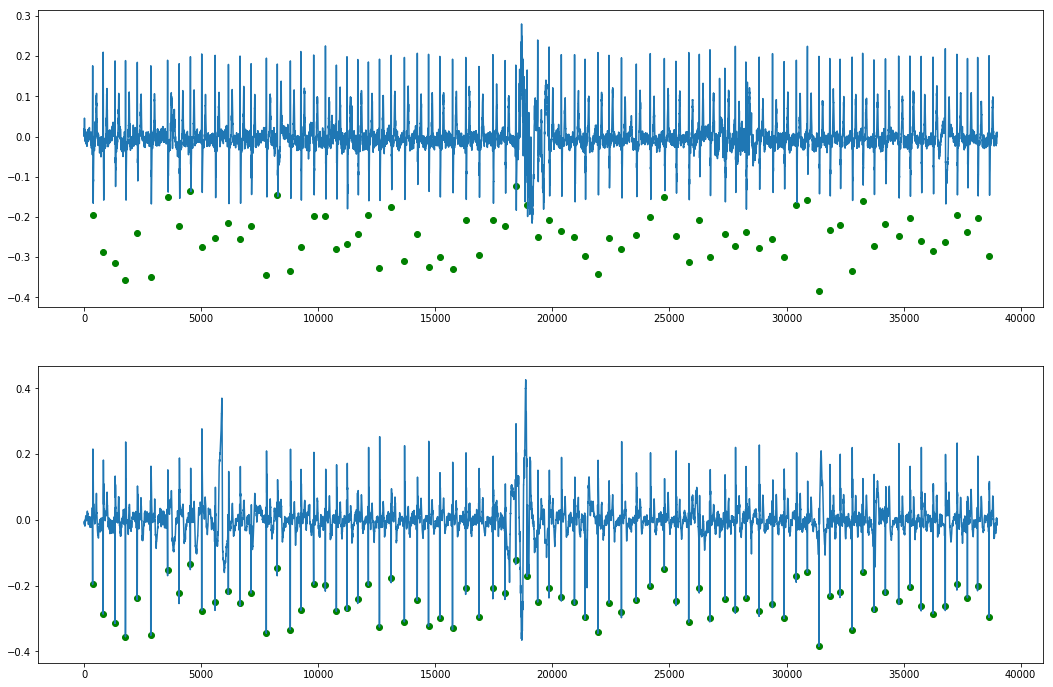

In [5]:
ecg = sio.loadmat(os.path.join(train_dataset_path,'TRAIN4283'))#TRAIN0151  TRAIN5151

ecg_data = wavelet(ecg["aVR"][0],'db4',4,2,4)

hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
qrs_inds = wp.xqrs_detect(ecg_data, 500)
# # print hard_peaks
plt.figure(figsize=(18,12))
for i in range(2):
    plt.subplot(2,1,i+1)
    if i == 0:
        plt.plot(ecg["I"][0])
    elif i == 1:
        plt.plot(ecg_data)
        #plt.plot(wavelet_db6(ecg["I"][0])) 
        
    #plt.scatter(hard_peaks, ecg_data[hard_peaksks], marker='o', c='r')
    plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
    #plt.plot(soft_peaks)
#plt.show()

In [149]:
data_info["dataSize"].value_counts()

5000     4048
7500     1253
10000     152
8000      146
15000     127
8500      104
9000       74
9500       72
7000       63
10500      63
11000      57
14500      48
12500      47
13000      40
11500      37
14000      29
13500      29
12000      26
6500       19
15500      13
16000      11
16500       7
19000       6
19500       4
18000       3
18500       3
6000        3
4500        2
21000       2
30000       1
27500       1
28000       1
45500       1
22500       1
21500       1
39000       1
20500       1
31500       1
17500       1
23500       1
24000       1
Name: dataSize, dtype: int64

# extend data ecg base QRS detect

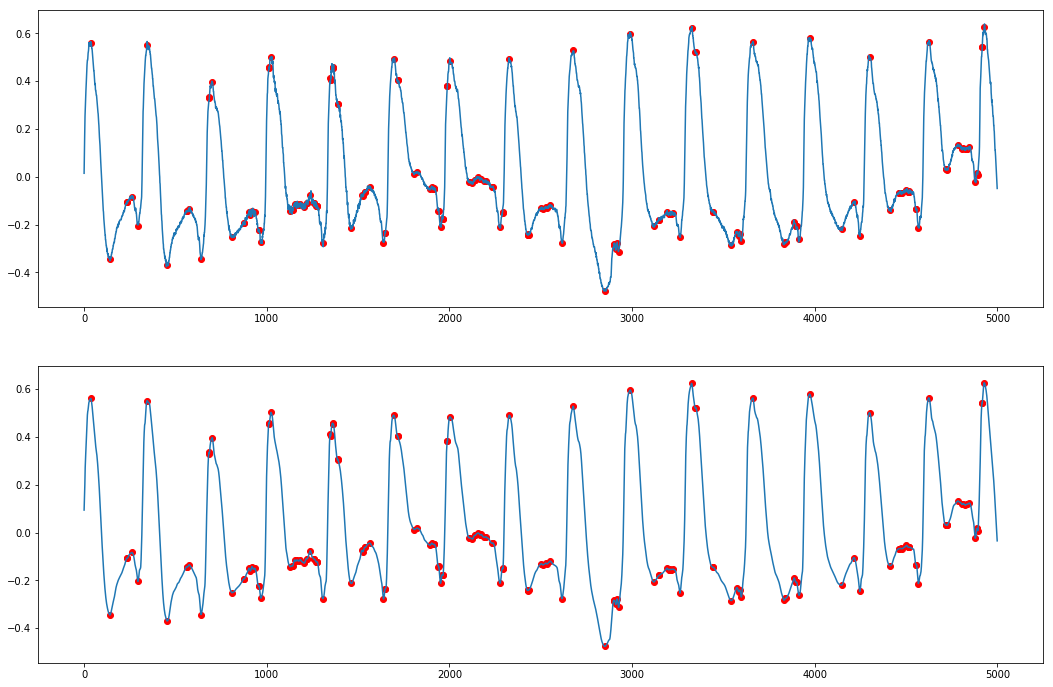

In [78]:
ecg = sio.loadmat(os.path.join(train_dataset_path,'TRAIN0140'))#TRAIN0151  TRAIN5151
sig = ecg["V1"][0]
ecg_data = wavelet(sig,'db4',4,2,4)

hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
qrs_inds = [0]#wp.xqrs_detect(ecg_data, 500)[0]
# # print hard_peaks
plt.figure(figsize=(18,12))
for i in range(2):
    plt.subplot(2,1,i+1)
    if i == 0:
        plt.plot(sig[:])
    elif i == 1:
        plt.plot(ecg_data[:])
        #plt.plot(wavelet_db6(ecg["I"][0])) 
        
    plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
    #plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
    #plt.plot(soft_peaks)
#plt.show()

In [76]:
soft_peaks

array([], dtype=int64)

In [75]:
hard_peaks

array([  37,  142,  236,  237,  262,  295,  347,  455,  563,  565,  575,
        640,  684,  685,  701,  810,  875,  877,  903,  910,  919,  927,
        934,  955,  957,  968, 1012, 1013, 1023, 1129, 1136, 1141, 1152,
       1158, 1166, 1174, 1182, 1205, 1219, 1221, 1238, 1260, 1261, 1272,
       1273, 1275, 1277, 1307, 1347, 1350, 1360, 1362, 1363, 1388, 1389,
       1463, 1520, 1526, 1536, 1537, 1563, 1639, 1648, 1649, 1694, 1716,
       1717, 1808, 1824, 1894, 1903, 1912, 1914, 1915, 1917, 1940, 1941,
       1952, 1960, 1962, 1963, 1965, 1988, 1989, 2003, 2107, 2110, 2126,
       2140, 2141, 2158, 2168, 2174, 2192, 2198, 2234, 2238, 2277, 2291,
       2293, 2328, 2428, 2430, 2431, 2432, 2433, 2503, 2512, 2527, 2534,
       2551, 2616, 2678, 2850, 2900, 2902, 2903, 2904, 2905, 2910, 2918,
       2926, 2990, 3119, 3148, 3149, 3191, 3200, 3206, 3210, 3211, 3214,
       3223, 3262, 3326, 3347, 3349, 3444, 3445, 3543, 3574, 3584, 3590,
       3598, 3661, 3832, 3840, 3841, 3887, 3896, 38

In [190]:
qrs_inds_II = wp.xqrs_detect(ecg["V6"][0], 500)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


In [187]:
qrs_inds_V1 = wp.xqrs_detect(ecg["V5"][0], 500)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


In [191]:
qrs_inds_II

array([  364,   814,  1320,  1767,  2271,  2849,  3565,  4058,  4539,
        5023,  5595,  6164,  6658,  7131,  7784,  8251,  8807,  9255,
        9804, 10307, 10775, 11226, 11689, 12141, 12614, 13115, 13679,
       14231, 14711, 15192, 15736, 16300, 16864, 17459, 17979, 18436,
       18922, 19372, 19859, 20381, 20946, 21393, 21944, 22416, 22950,
       23584, 24181, 24780, 24989, 25098, 25239])

In [203]:
qrs_inds_V1[:]

array([  364,   814,  1320,  1767,  2270,  2848,  3564,  4058,  4539,
        5022,  5594,  6163,  6658,  7131,  7784,  8250,  8807,  9254,
        9804, 10307, 10775, 11226, 11688, 12140, 12614, 13114, 13678,
       14230, 14710, 15192, 15736, 16299, 16863, 17459, 17978, 18436,
       18921, 19372, 19858, 20381, 20946, 21393, 21944, 22415, 22950,
       23583, 24180, 24779, 25277, 25823, 25974, 26275, 26478, 26729,
       27110, 27365, 27813, 28262, 28830, 29401, 29895, 30419, 30892,
       31385, 31846, 32286, 32799, 33251, 33732, 34225, 34789, 35268,
       35750, 36257, 36782, 37277, 37728, 38163, 38649])

In [197]:
len(qrs_inds_V1)

79

In [198]:
len(qrs_inds_II)

51

In [271]:
np.diff(qrs_inds_V1).mean()

490.8333333333333

In [272]:
np.diff(qrs_inds_II).mean()

497.5

In [270]:
0.4*500

200.0

In [268]:
0.2*500

100.0

In [266]:
0.075*500

37.5

In [4]:
def qrs_matched_degree(qrs_inds1,qrs_inds2):
    thred = 0
    flag = False
    index = 0
    if len(qrs_inds1) >= len(qrs_inds2):
        length_qrs = len(qrs_inds1)
        index = 1
        qrs_inds = qrs_inds1
    else:
        length_qrs = len(qrs_inds2)
        index = 2
        qrs_inds = qrs_inds2
        
    for inds in qrs_inds1:
        
        step = 0.15*500
        
        if inds>step:
            min_inds = inds-step
        else:
            min_inds = inds
        max_inds = inds+step
        
        for inds2 in qrs_inds2:
            if inds2 > min_inds and inds2 < max_inds:
                thred += 1
                #print(inds2)
            elif inds2 > max_inds:
                break
            else:
                pass
    if thred >= int(length_qrs*0.9):
        flag = True
    return thred,flag,length_qrs,index,qrs_inds

In [7]:
for mat_file in tqdm(train_files[:1]):
    sig = sio.loadmat(os.path.join(train_dataset_path,mat_file))#TRAIN0151  TRAIN5151
    ecg = wavelet(sig[ch_name][0],'db4',4,2,4)
    qrs_index = 0
    qrs_flag = False
    channel_name = ['V6','aVF', 'V4','aVL','V1','aVR', 'V5','III','V3', 'I','V2','II']
    for i in range(12):
        if qrs_index == 1:
            ch_name = channel_name.pop()
            qrs_inds_2 = wp.xqrs_detect(ecg, 500,verbose=False)
        if qrs_index == 2:
            ch_name = channel_name.pop()
            qrs_inds_1 = wp.xqrs_detect(ecg, 500,verbose=False)
        else:
            ch_name = channel_name.pop()
            qrs_inds_1 = wp.xqrs_detect(ecg, 500,verbose=False)
            ch_name = channel_name.pop()
            qrs_inds_2 = wp.xqrs_detect(ecg, 500,verbose=False)

        qrs_thred,qrs_flag,qrs_length,qrs_index,qrs_inds = qrs_matched_degree(qrs_inds_1,qrs_inds_2)

        if qrs_flag == True:
            #print(mat_file)
            #print(qrs_length)
            break
        if qrs_flag == False and i == 11:
            print(mat_file)
            print(qrs_length)


  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'ch_name' is not defined

In [108]:
def read_data_extend_qrs(data_path,split="Train",preprocess=False,fs=500,newFs=256,winSecond=10,winNum=10,n_index=0):
    """ Read data """

    # Fixed params
    #n_index = 0
    n_class = 9
    winSize = winSecond*fs
    new_winSize = 23296 #winSecond*newFs
    # Paths
    path_signals = os.path.join(data_path, split)

    # Read labels and one-hot encode
    #label_path = os.path.join(data_path, "reference.txt")
    #labels = pd.read_csv(label_path, sep='\t',header = None)
    #labels = pd.read_csv("reference.csv")

    # Read time-series data
    channel_files = os.listdir(path_signals)

    channel_files.sort()
    n_channels = 12#len(channel_files)

    # Initiate array
    list_of_channels = []
    
    X = np.zeros((len(channel_files), new_winSize, n_channels))# 
    i_ch = 0
    
    channel_name = ['V6', 'aVF', 'I', 'V4', 'V2', 'aVL', 'V1','II', 'aVR', 'V3', 'III', 'V5']
    channel_mid_name = ['II','aVR','V2','V5']
    channel_post_name = ['III','aVF','V3','V6']
    
    for i_ch,fil_ch in enumerate(channel_files[4312:]):#tqdm
        #print(fil_ch)
        if i_ch%500 == 0:
            print(fil_ch)
            
        ecg = sio.loadmat(os.path.join(path_signals,fil_ch))
        ecg_length = ecg["I"].shape[1]

        qrs_index = 0
        qrs_flag = False
        ch_names = ['V6','aVF', 'V4','aVL','V1','aVR', 'V5','III','V3', 'I','V2','II']
        for i in range(12):
            try:
                if qrs_index == 1:
                    ch_name = ch_names.pop()
                    qrs_inds_2 = wp.xqrs_detect(wavelet(ecg[ch_name][0],'db4',4,2,4), 500,verbose=False)
                if qrs_index == 2:
                    ch_name = ch_names.pop()
                    qrs_inds_1 = wp.xqrs_detect(wavelet(ecg[ch_name][0],'db4',4,2,4), 500,verbose=False)
                else:
                    ch_name = ch_names.pop()
                    qrs_inds_1 = wp.xqrs_detect(wavelet(ecg[ch_name][0],'db4',4,2,4), 500,verbose=False)
                    ch_name = ch_names.pop()
                    qrs_inds_2 = wp.xqrs_detect(wavelet(ecg[ch_name][0],'db4',4,2,4), 500,verbose=False)
            except IndexError:
                print("pop empty : ",fil_ch)
            qrs_thred,qrs_flag,qrs_length,qrs_index,qrs_inds = qrs_matched_degree(qrs_inds_1,qrs_inds_2)
            #print(ch_names)
            #print(i)
            if qrs_flag == True:
                break
            if qrs_flag == False and i == 10:
                print("not long qrs : ",fil_ch)
                print(qrs_length)
                break
        try:
            rr_diff = int(np.diff(qrs_inds[-8:]).mean())
        except ValueError:
            print("No QRS : ",fil_ch)
            continue
            
        #print(np.diff(qrs_inds[:]))
        if ecg_length - qrs_inds[-1] > rr_diff+20:
            print(fil_ch)
            print(ecg_length - qrs_inds[-1])
            print(rr_diff)
            print("lou jian")
        
        if rr_diff >= 0.4*500 + 0.2*500:
            insert = np.zeros((1,int(rr_diff - .4*500 - 0.2*500)))
            if qrs_inds[-1] + 0.4*500 < ecg_length:
                end_i = qrs_inds[-1] + 0.4*500
            else:
                end_i = ecg_length
            if qrs_inds[0] - 0.2*500> 0 :
                start_i = qrs_inds[0] - 0.2*500
            else:
                start_i = 0
        else:
            try :
                insert = np.zeros((1,int(rr_diff - .3*500 - 0.1*500)))
            except ValueError:
                print('negative : ',fil_ch)
                print(rr_diff)
                
            if qrs_inds[-1] + 0.3*500 < ecg_length:
                end_i = qrs_inds[-1] + 0.3*500
            else:
                end_i = ecg_length
            if qrs_inds[0] - 0.1*500> 0 :
                start_i = qrs_inds[0] - 0.1*500
            else:
                start_i = 0
                
        start_i = int(start_i)
        end_i = int(end_i)

        slide_steps = int((ecg_length- winSize)/winSecond)
        
        if ecg_length <= 4500:
            slide_steps = 0
        
        new_winSize = 91 * 256
        ecg_channels = np.zeros((new_winSize, n_channels))
        
        for i_n,ch_name in enumerate(channel_name):
            #print(insert.shape)
            sig_ch = np.hstack((ecg[ch_name][:,:end_i][0],insert[0],ecg[ch_name][:,start_i:end_i][0]))
            for i in range(10):
                #print(sig_ch.shape)
                if sig_ch.shape[0] < 91 * 500:
                    sig_ch = np.hstack((sig_ch,insert[0],ecg[ch_name][:,start_i:end_i][0]))
                else:
                    sig_ch = sig_ch[:91*500]
                    break
            #print(sig_ch.shape)
                
            ecg_channels[:,i_n] = signal.resample(sig_ch,new_winSize).T
            
            if preprocess:
                data = ecg_preprocessing(ecg_channels[:,i_n].reshape(1,new_winSize), 'sym8', 8, 3, newFs)
                ecg_channels[:,i_n] = data[0]
            else:
                pass
                ecg_channels[:,i_n] = ecg_channels[:,i_n]
        #print(ecg_channels.shape)
        X[i_ch,:,:] = ecg_channels

    return X

In [ ]:
#no QRS : TRAIN0140 TRAIN3063 TRAIN3223 TRAIN3809 TRAIN3822  
#not long qrs: TRAIN0796 TRAIN2029 TRAIN3312 TRAIN4002 TRAIN4219
#negative:TRAIN2168  TRAIN2569 TRAIN3561

In [109]:
aa = read_data_extend_qrs(os.getcwd(),preprocess=True,n_index=5)

TRAIN4313.mat


KeyboardInterrupt: 

In [385]:
aa[0].shape

(23296, 12)

In [386]:
aa[0][:,0].shape

(23296,)

In [19]:
from scipy.signal import medfilt



In [160]:
sig = aa[0][:,0]
np.array(sig).max()

1.1378576144280348

In [154]:
np.array(sig).min()

-0.47824

In [144]:
np.mean(sig)

0.020885423999999996

In [145]:
np.std(sig)

0.26671368953306507

In [158]:
((sig - np.mean(sig))/np.std(sig)*np.std(sig)).max()

0.6183945759999999

In [159]:
((sig - np.mean(sig))/np.std(sig)*np.std(sig)).min()

-0.499125424

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


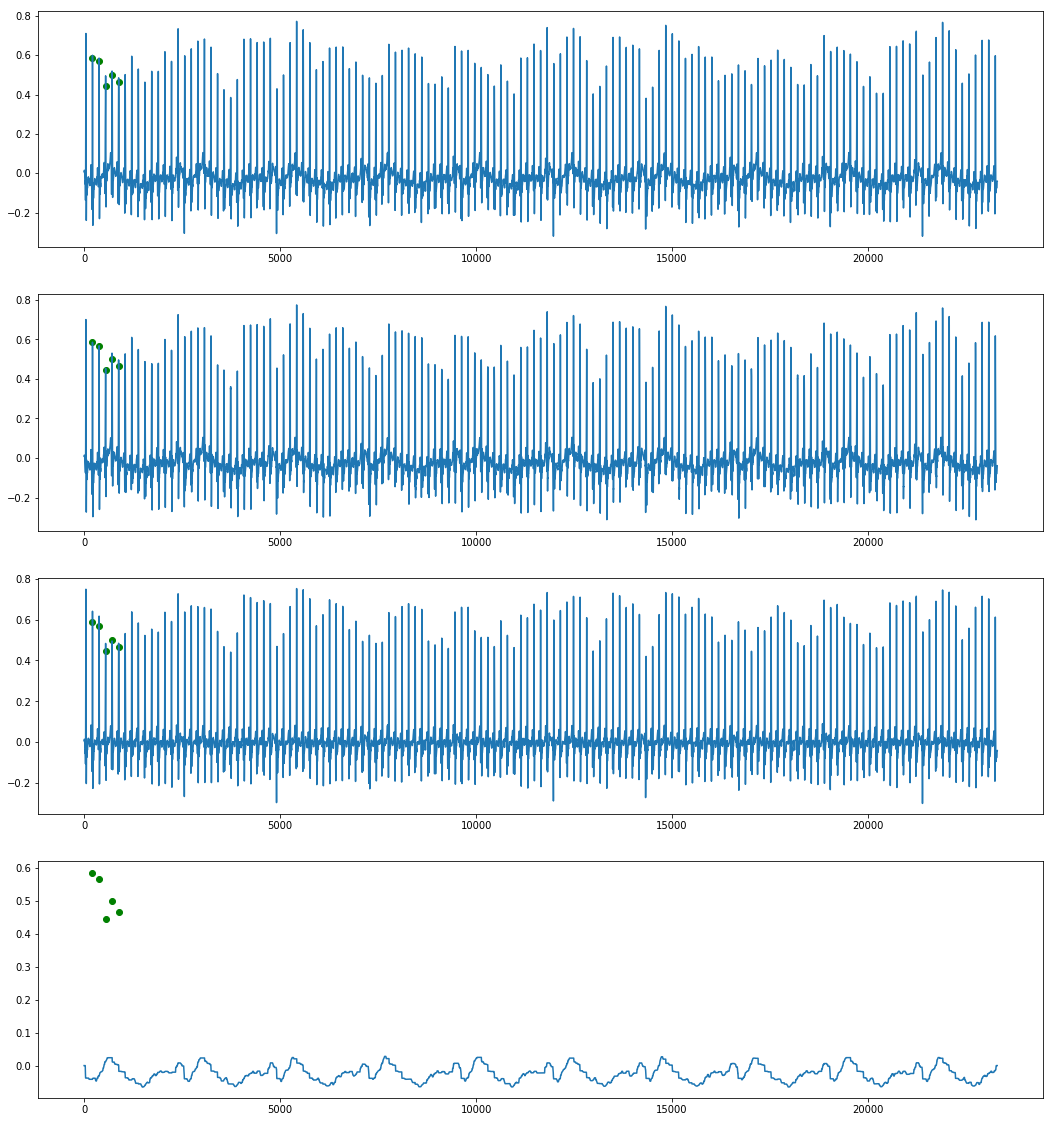

In [39]:
sig = aa[4][:,0]#ecg["aVR"][0]
ecg_data = wavelet(sig,'db4',4,2,4)

first_filtered = medfilt(sig,71)
second_filtered = medfilt(first_filtered,215)
base_sig = sig - second_filtered

hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
qrs_inds = wp.xqrs_detect(ecg_data, 500)[:5]
# # print hard_peaks
plt.figure(figsize=(18,20))
th = 24000
for i in range(4):
    plt.subplot(4,1,i+1)
    if i == 0:
        plt.plot(sig[:th])
    elif i == 1:
        plt.plot(ecg_data[:th])
    elif i == 2:
        plt.plot(base_sig[:th])
    elif i == 3:
        plt.plot(sig[:th] - base_sig[:th])
        #plt.plot(wavelet_db6(ecg["I"][0])) 
        
    #plt.scatter(hard_peaks, ecg_data[hard_peaksks], marker='o', c='r')
    plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
    #plt.plot(soft_peaks)
#plt.show()